# Dependencies

In [2]:
!pip install swig
!pip install "gymnasium[box2d]" pygame matplotlib ipython


[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from IPython.display import HTML, Javascript, display

import base64
import io
from PIL import Image
import string


# CEM algorithm implementation

In [4]:
class CEM:
    def __init__(
        self,
        dim: int,
        bounds: np.ndarray,
        population_size: int = 500,
        elite_frac: float = 0.1,
        max_iters: int = 50,
        smoothing: float = 0.7,
        seed: int = None,
    ):
        self.dim = dim
        self.bounds = bounds
        self.pop_size = population_size
        self.n_elite = max(1, int(np.ceil(elite_frac * population_size)))
        self.max_iters = max_iters
        self.alpha = smoothing
        self.rng = np.random.default_rng(seed)

        self.best_obj_history = []

    def optimize(self, x_init: np.ndarray, objective):
        mu = x_init.copy()
        sigma = (self.bounds[1] - self.bounds[0]) / 2.0

        self.best_obj_history = []

        for i in range(self.max_iters):
            # 1. random sample x and clip with bounds
            samples = self.rng.normal(mu, sigma, size=(self.pop_size, self.dim))
            samples = np.clip(samples, self.bounds[0], self.bounds[1])

            # 2. query y values from sampled x
            ys = objective(samples).ravel()

            # 3. get top k minimum (x,y)
            elite_idxs = np.argsort(ys)[:self.n_elite]
            elite_samples = samples[elite_idxs]

            # 3. calculate mean, std from top k samples
            new_mu = elite_samples.mean(axis=0)
            new_sigma = elite_samples.std(axis=0)

            # 3. update mean and sigma
            mu = self.alpha * mu + (1 - self.alpha) * new_mu
            sigma = self.alpha * sigma + (1 - self.alpha) * new_sigma

            # [optional] For debug, log best y values and mean y values, etc ..
            best_y = ys[elite_idxs[0]]
            mean_y = ys.mean()
            self.best_obj_history.append(best_y)
            print(f"Iteration: {i} / best_y: {best_y} / mean_y: {mean_y}")

        # return current mean
        return mu

    def visualize(self):
        plt.figure()
        plt.plot(np.arange(1, len(self.best_obj_history) + 1), self.best_obj_history, marker='o')
        plt.title("Best Value per Iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Objective (Lower is Better)")
        plt.show()

# Objective function

In [ ]:
def objective_vec(train_env, batch: np.ndarray) -> np.ndarray:
    """
    Generic vectorized discrete-action objective for CEM (to be MINIMIZED).
    Works for CartPole (action_dim=2) or LunarLander (action_dim=4) or any other discrete gym env.

    Parameters
    ----------
    train_env : VectorEnv
        A vectorized gymnasium environment.
    batch : np.ndarray, shape (N, D)
        Population of parameter vectors. Each θ has length
            obs_dim * action_dim  +  action_dim

    Returns
    -------
    np.ndarray, shape (N,)
        Negative average reward per candidate (CEM will minimize).
    """
    N, D = batch.shape
    obs_dim = train_env.single_observation_space.shape[0]
    action_dim = train_env.single_action_space.n

    # sanity check
    assert D == obs_dim * action_dim + action_dim, (
        f"Expected θ to be length {obs_dim*action_dim + action_dim}, "
        f"got {D}"
    )

    results = np.zeros(N, dtype=float)

    for i in range(N):
        theta = batch[i]
        # 1. unpack θ → W, b
        W = theta[: obs_dim * action_dim].reshape(obs_dim, action_dim)
        b = theta[obs_dim * action_dim :]

        # 2. get sum of rewards with policy and env
        # Note: sum of rewards should be maximized, but CEM works to minimize objective. So we should change the sign.
        obs, _ = train_env.reset()
        done_mask = np.zeros(train_env.num_envs, dtype=bool)
        cum_rewards = np.zeros(train_env.num_envs, dtype=float)

        # run until each sub-env ends
        while not done_mask.all():
            # compute per‐env logits and pick argmax
            logits = obs.dot(W) + b        # (num_envs, action_dim)
            actions = np.argmax(logits, axis=1)

            obs, rewards, terminated, truncated, _ = train_env.step(actions)
            active = ~done_mask
            cum_rewards[active] += rewards[active]
            done_mask |= (terminated | truncated)

        # store –CEM minimizes, so negate average reward
        results[i] = -cum_rewards.mean()

    return results


## Helper function - evaluation

In [ ]:
def animate_policy(
    theta: np.ndarray,
    env_name: str = "CartPole-v1",
    max_steps: int = 500,
    interval: int = 100,
    goal_reward: float = None
) -> HTML:
    """
    Render a discrete-action policy for any Gymnasium env and display a reward curve
    with an optional goal_reward marker.

    Parameters
    ----------
    theta : np.ndarray, shape=(obs_dim*action_dim + action_dim,)
        Flattened policy parameters.
    env_name : str
        Gym environment ID.
    max_steps : int
        Max timesteps to run.
    interval : int
        Milliseconds between animation frames.
    goal_reward : float or None
        If provided, draw a horizontal line at this reward and a vertical line
        at the first step where cumulative reward ≥ goal_reward.
    """
    # Setup env
    env = gym.make(env_name, render_mode="rgb_array")
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    assert theta.size == obs_dim*action_dim + action_dim, \
        f"θ length should be {obs_dim*action_dim + action_dim}, got {theta.size}"
    W = theta[:obs_dim*action_dim].reshape(obs_dim, action_dim)
    b = theta[obs_dim*action_dim:]

    # Rollout and collect frames & rewards
    obs, _ = env.reset()
    frames, rewards = [], []
    total = 0.0
    goal_step = None

    for t in range(max_steps):
        frame = env.render()
        frames.append(frame)
        logits = obs.dot(W) + b
        action = int(np.argmax(logits))
        obs, r, terminated, truncated, _ = env.step(action)
        total += r
        rewards.append(total)
        if goal_reward is not None and goal_step is None and total >= goal_reward:
            goal_step = t+1
        if terminated or truncated:
            frames.append(env.render())
            rewards.append(total)
            break
    env.close()

    # Encode frames
    uris = []
    for f in frames:
        img = Image.fromarray(f)
        buf = io.BytesIO()
        img.save(buf, format="PNG")
        uris.append("data:image/png;base64," + base64.b64encode(buf.getvalue()).decode())

    # Plot reward curve with goal markers
    fig, ax = plt.subplots()
    ax.plot(range(len(rewards)), rewards, marker='o')
    if goal_reward is not None:
        ax.axhline(goal_reward, color='red', linestyle='--', label=f"Goal = {goal_reward}")
        if goal_step is not None:
            ax.axvline(goal_step, color='green', linestyle='--',
                       label=f"Reached at t={goal_step}")
        ax.legend()
    ax.set_title("Cumulative Reward")
    ax.set_xlabel("Step")
    ax.set_ylabel("Total Reward")
    plt.tight_layout()

    buf = io.BytesIO()
    fig.savefig(buf, format="PNG")
    plt.close(fig)
    graph_uri = "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode()

    # Build HTML
    total_frames = len(frames)
    w = frames[0].shape[1]
    h = frames[0].shape[0]

    charset = string.ascii_letters + string.digits
    chars = np.array(list(charset))
    picks = np.random.choice(chars, size=6)
    # Join them into one string
    frame_id = ''.join(picks)


    html = f"""
    <div style="text-align:center;">
      <img id="cem_frame_{frame_id}" width="{w}" height="{h}" style="border:1px solid #333"/>
      <p id="frame_counter_{frame_id}">Frame: 1 / {total_frames}</p>
      <div>
        <img src="{graph_uri}" width="400"/>
      </div>
    </div>
    """
    display(HTML(html))

    js = f"""
    const frames = [{','.join(f"'{u}'" for u in uris)}];
    let idx = 0, total = frames.length;
    const img = document.getElementById('cem_frame_{frame_id}'),
          counter = document.getElementById('frame_counter_{frame_id}');
    img.src = frames[0];
    setInterval(() => {{
      idx = (idx + 1) % total;
      img.src = frames[idx];
      counter.innerText = 'Frame: ' + (idx+1) + ' / ' + total;
    }}, {interval});
    """
    display(Javascript(js))


# Optimization example : Cartpole
- [Gymnasium docs](https://gymnasium.farama.org/v0.29.0/environments/classic_control/cart_pole/)
- Takes about 30 sec ~ 1 min to optimize

In [ ]:
train_env = gym.make_vec(
    "CartPole-v1",
    num_envs = 3,
    vectorization_mode = "vector_entry_point"
)

# You need to define
# 1. dimension of linear policy weight
# 2. bound where we should search policy
# 3. hyperparameters of CEM. population_size, elite_frace, max_iters, smoothing ratio etc...
# ----------------------------------------------------------------

obs_dim    = train_env.single_observation_space.shape[0]
action_dim = train_env.single_action_space.n
dim        = obs_dim * action_dim + action_dim

bounds = np.array([[-5]*dim, [5]*dim])
cem = CEM(dim=dim, bounds=bounds, population_size=200, elite_frac=0.1, max_iters=10, smoothing=0.25)

x0 = np.zeros(dim)

best_theta = cem.optimize(
    x0,
    lambda batch: objective_vec(train_env, batch)
)

# ----------------------------------------------------------------


Iteration: 0 / best_y: -244.33333333333334 / mean_y: -21.80166666666667
Iteration: 1 / best_y: -500.0 / mean_y: -44.94333333333333
Iteration: 2 / best_y: -500.0 / mean_y: -58.655
Iteration: 3 / best_y: -500.0 / mean_y: -107.85333333333332
Iteration: 4 / best_y: -500.0 / mean_y: -155.19
Iteration: 5 / best_y: -500.0 / mean_y: -246.87666666666664
Iteration: 6 / best_y: -500.0 / mean_y: -313.165
Iteration: 7 / best_y: -500.0 / mean_y: -329.75833333333327
Iteration: 8 / best_y: -500.0 / mean_y: -396.91833333333335
Iteration: 9 / best_y: -500.0 / mean_y: -412.93
Best avg reward: 500.0


Test if your policy is working well.


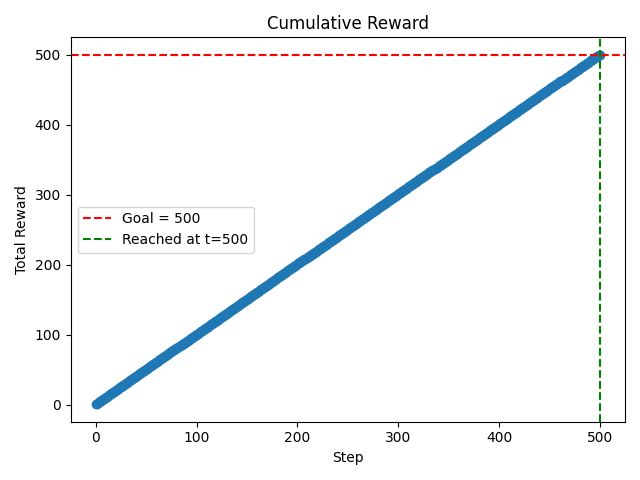

<IPython.core.display.Javascript object>

In [40]:
animate_policy(best_theta, max_steps=500, interval=100, env_name='CartPole-v1', goal_reward=500)

# Optimization example : Lunar Lander
- [Gymnasium docs](https://gymnasium.farama.org/v0.29.0/environments/box2d/lunar_lander/)
- Takes about 10 min to optimize

In [ ]:
train_env = gym.make_vec(
    "LunarLander-v3",
    num_envs = 3,
)

# You need to define
# 1. dimension of linear policy weight
# 2. bound where we should search policy
# 3. hyperparameters of CEM. population_size, elite_frace, max_iters, smoothing ratio etc...
# ----------------------------------------------------------------

obs_dim    = train_env.single_observation_space.shape[0]
action_dim = train_env.single_action_space.n
dim        = obs_dim * action_dim + action_dim
bounds = np.array([[-10]*dim, [10]*dim])
x0 = np.zeros(dim)

cem = CEM(dim=dim, bounds=bounds, population_size=250, elite_frac=0.1, max_iters=100, smoothing=0.5)

best_theta = cem.optimize(
    x0,
    lambda batch: objective_vec(train_env, batch)
)

# ----------------------------------------------------------------


Iteration: 0 / best_y: 18.649723898523117 / mean_y: 496.0941087027922
Iteration: 1 / best_y: -29.578290655035783 / mean_y: 383.6942153360998
Iteration: 2 / best_y: 80.76817217768263 / mean_y: 343.3434824187643
Iteration: 3 / best_y: 35.84867729620173 / mean_y: 267.20888356900736
Iteration: 4 / best_y: 1.4093390789238167 / mean_y: 232.42974166222413
Iteration: 5 / best_y: 36.65391774536571 / mean_y: 195.5513640236135
Iteration: 6 / best_y: -25.984195699243276 / mean_y: 183.69344867544126
Iteration: 7 / best_y: 26.363191461636685 / mean_y: 157.31581396336864
Iteration: 8 / best_y: -42.3313020412018 / mean_y: 161.14425353256794
Iteration: 9 / best_y: -73.4679975030249 / mean_y: 155.88382541729405
Iteration: 10 / best_y: -31.85558802696436 / mean_y: 154.23098724935883
Iteration: 11 / best_y: -80.74172517524653 / mean_y: 157.59131185037904
Iteration: 12 / best_y: -18.651764665592584 / mean_y: 149.13520407057965
Iteration: 13 / best_y: -86.52955273812883 / mean_y: 141.7620574218221
Iteration

Test if your policy is working well.


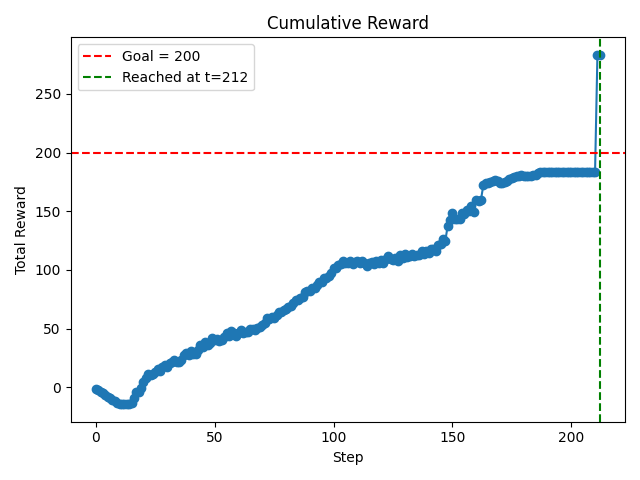

<IPython.core.display.Javascript object>

In [38]:
animate_policy(best_theta, max_steps=500, interval=100, env_name='LunarLander-v3', goal_reward=200)